In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import pymc as pm
import arviz as az
from scipy import stats
import xarray as xr

from src.utils import basic as utils

# Linear Regression

* Geocentric
* Gaussian
    * Generative: Summed fluctuations tend toward Normal distribution
    * Inferential: For estimating mean and variance, the Normal distribution is least informative (fewest assumptions), in the maximum entropy sense

### Generative Normal distribution from summation of decisions

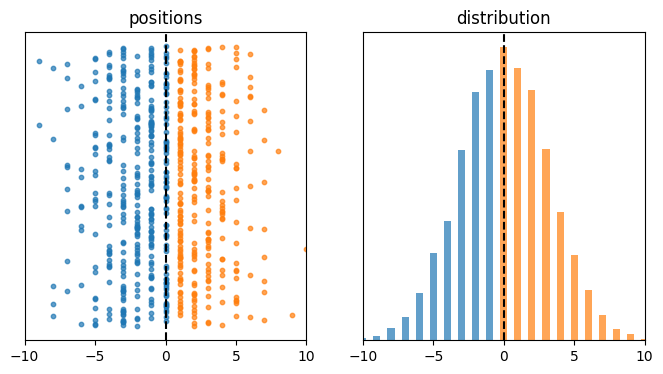

In [2]:
n_people = 10_000
n_steps = 1_000

step_size = .1
steps = step_size * (2 * stats.bernoulli(p=.5).rvs(size=(n_people, n_steps)) - 1)

positions = np.round(np.sum(steps, axis=1))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(axs[0])
plt.axvline(0, color='k', linestyle='--')
for idx, pos in enumerate(positions[::15]):
    color = 'C1' if pos > 0 else 'C0'
    plt.scatter(x=pos, y=idx, color=color, alpha=.7, s=10)
    
plt.xlim([-10, 10])
plt.yticks([])
plt.title("positions")

# plot histogram of positions
position_unique, position_counts = np.unique(positions, return_counts=True)
positive_idx = position_unique >= 0
negative_idx = position_unique < 0
plt.sca(axs[1])
plt.bar(position_unique[positive_idx], position_counts[positive_idx], width=.5, color='C1', alpha=.7)
plt.bar(position_unique[negative_idx], position_counts[negative_idx], width=.5, color='C0', alpha=.7)
plt.axvline(0, color='k', linestyle='--')
plt.xlim([-10, 10])
plt.yticks([])
plt.title("distribution");


## Drawing the Owl
1. State question
2. Sketch causal assumptions -> DAG
3. Define generative model -> Generate Data
4. Use generative model to build an estimator


## Linear Regression


### (1) Question
Describe the association between weight an height. We will focus on adult weights as it approximately linear relationship

Text(0.5, 1.0, 'Adult Howell Dataset')

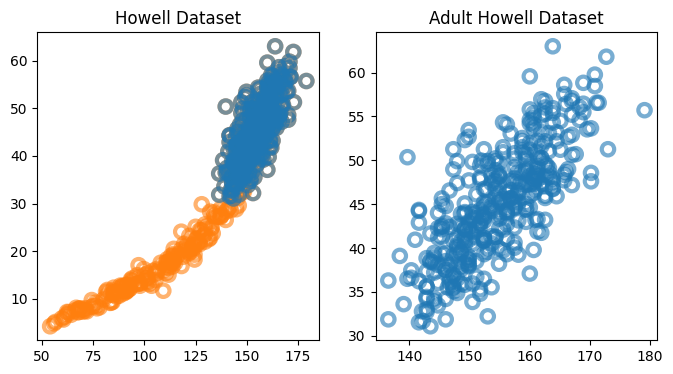

In [66]:
HOWELL = utils.load_data("Howell1")
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(axs[0])
utils.plot_scatter(HOWELL.height, HOWELL.weight, color='C1')
plt.title("Howell Dataset")

ADULT_HOWELL = HOWELL[HOWELL.age >= 18]
plt.sca(axs[0])
utils.plot_scatter(ADULT_HOWELL.height, ADULT_HOWELL.weight)
plt.sca(axs[1])
utils.plot_scatter(ADULT_HOWELL.height, ADULT_HOWELL.weight)
plt.title("Adult Howell Dataset")



### (2) Scientific Model

How does height influences weight?

H -> W
W = f(H)

### (3) Generative Models

1. Dynamic - Relationship changes over time
2. Static - constant trend over time

W = f(H, U) -> Weight is a function of height, H and unobserved variable, U.

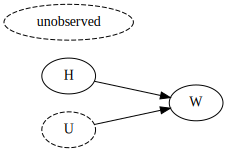

In [16]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("U", "W")
    ],
    node_props={
        "U": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    graph_direction="LR"
)

#### Linear Regression Model
$$W = {\beta}H + U$$

#### Generative model description:

$$ W_i \sim \beta H_i + U_i$$
$$ U_i \sim Normal(0,\sigma) $$
$$ H_i \sim Uniform(130, 170)

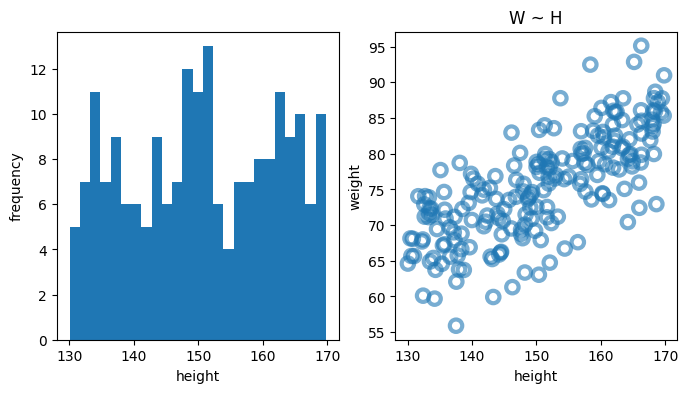

In [19]:
def simulate_weight(H, beta, sigma):
    n_heights = len(H)
    # unobserved noise
    U = stats.norm.rvs(loc=0, scale=sigma, size=n_heights)
    # simulate weight
    W = beta * H + U
    return W

n_heights = 200
MIN_HEIGHT = 130
MAX_HEIGHT = 170

H = stats.uniform.rvs(loc=MIN_HEIGHT, scale=MAX_HEIGHT - MIN_HEIGHT, size=n_heights)
W = simulate_weight(H, beta=0.5, sigma=5)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.sca(axs[0])
plt.hist(H, bins=25)
plt.xlabel("height")
plt.ylabel("frequency")

plt.sca(axs[1])
utils.plot_scatter(H, W)
plt.xlabel("height")
plt.ylabel("weight");
plt.title("W ~ H");

**Linear Regression**

Estimate how the average weight changes with a change in height:
$$ E[W_i|H_i] = \alpha + \beta H_i$$


- $E[W_i|H_i]$: *average weight* conditioned on height
- $\alpha$: *intercept* of line
- $\beta$: slope of libe

**Posterior Distribution**

$$ p(\alpha, \beta, \sigma) = \frac{p(W_i|\alpha , \beta , \sigma)}{Z}$$



In [22]:
def linear_model(x, intercept, slope):
    return intercept + slope * x

# posterior function required for simulation
def linear_regression_posterior(x_obs, y_obs, intercept_grid, slope_grid, likelihood_prior_std = 1.0):
    # convert params to 1-d arrays
    if np.ndim(intercept_grid) > 1:
        intercept_grid = intercept_grid.ravel()
    
    if np.ndim(slope_grid) > 1:
        slope_grid = slope_grid.ravel()
        
    log_prior_intercept = stats.norm(0,1).logpdf(intercept_grid)
    log_prior_slope = stats.norm(0,1).logpdf(slope_grid)
    
    log_likelihood = np.array(
        [
            stats.norm(
                intercept + slope * x_obs,
                likelihood_prior_std
            ).logpdf(y_obs) for intercept, slope in zip(intercept_grid, slope_grid)
        ]
    ).sum(axis=1)
    
    # posterior is proportional to likelihood * prior
    log_posterior = log_likelihood + log_prior_intercept + log_prior_slope
    
    # convert back to natural scale
    posterior = np.exp(log_posterior - np.max(log_posterior))
    
    return posterior

Simulate Posterior Updates

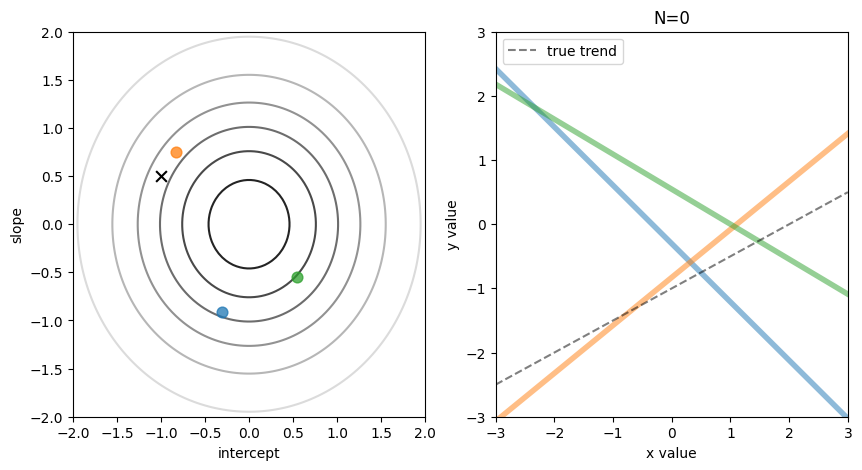

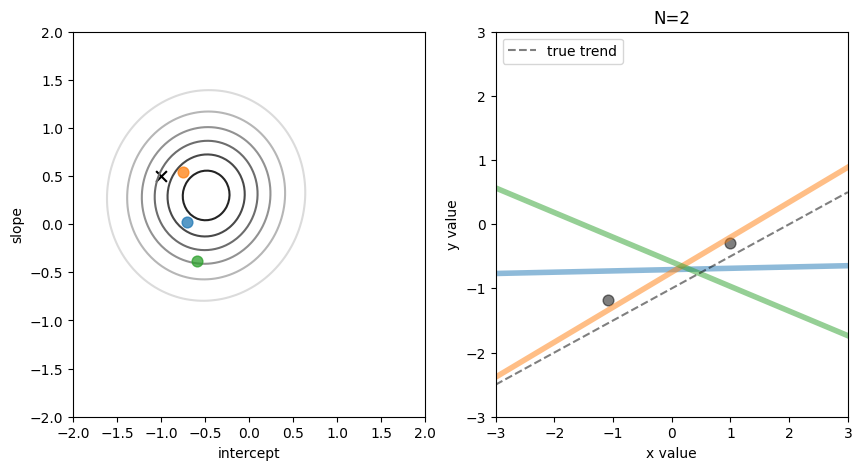

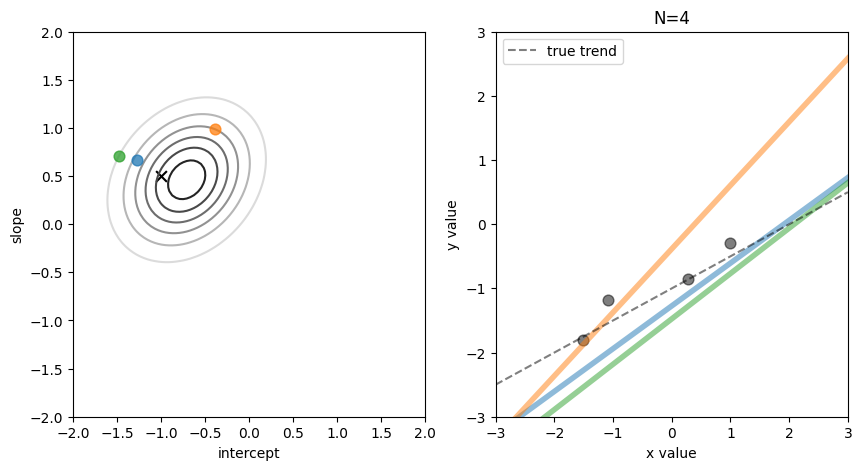

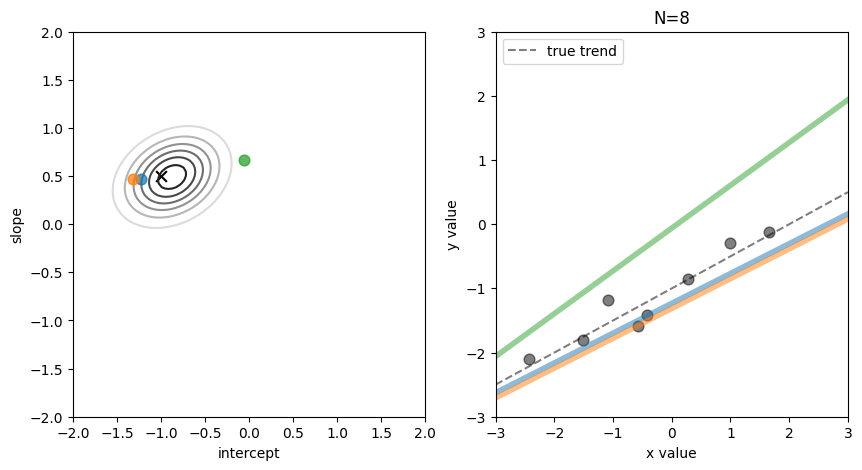

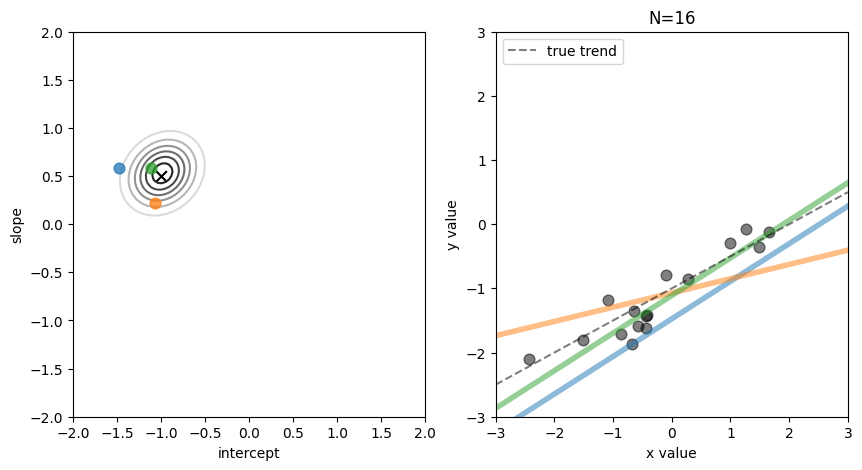

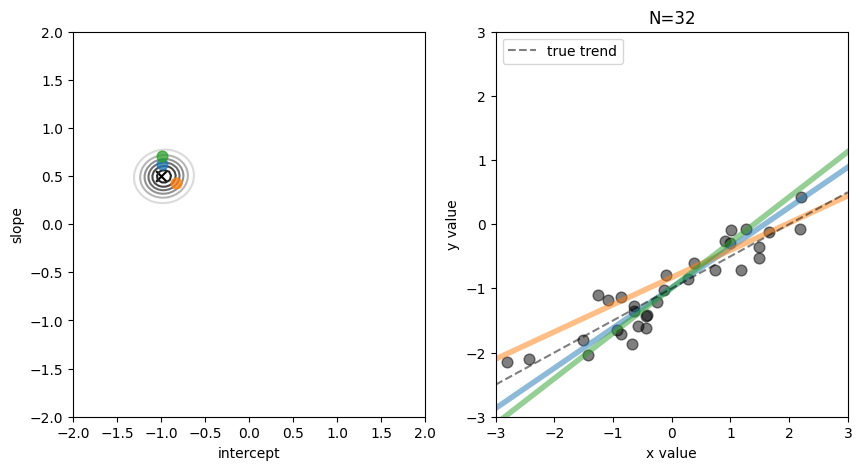

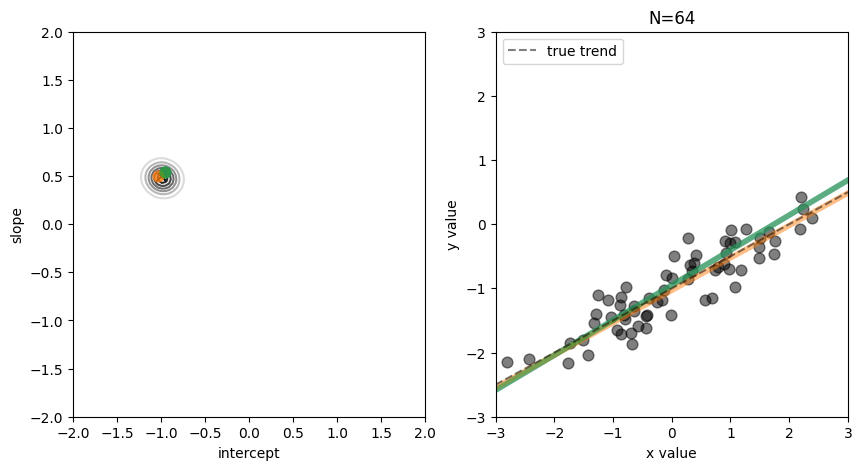

In [36]:
# Generate standardized regression data for demo
np.random.seed(123)
RESOLUTION = 100
N_DATA_POINTS = 64

# Ground truth parameters
SLOPE = 0.5
INTERCEPT = -1

# Generate data
x = stats.norm().rvs(N_DATA_POINTS)
y = INTERCEPT + SLOPE * x + stats.norm().rvs(N_DATA_POINTS) * .25

slope_grid = np.linspace(-2, 2, RESOLUTION)
intercept_grid = np.linspace(-2, 2, RESOLUTION)

# Vary the sample size to show how the posterior adapts to more and more data
for n_samples in [0, 2, 4, 8, 16, 32, 64]:
    # Run simulation
    utils.simulate_2_parameter_bayesian_learning(
        x_obs=x[:n_samples],
        y_obs=y[:n_samples],
        param_a_grid=intercept_grid,
        param_b_grid=slope_grid,
        true_param_a=INTERCEPT,
        true_param_b=SLOPE,
        model_func=linear_model,
        posterior_func=linear_regression_posterior,
        param_labels=["intercept", "slope"],
        data_range_x=(-3, 3),
        data_range_y=(-3, 3),
    )


### (4) Validating the model
#### Validate Assumptions with **Prior Predictive Distributions**

- Priors should express scientific knowledge, _but softly_
- *There are no correct priors*, only those that are scientifically justifiable

(30.0, 70.0)

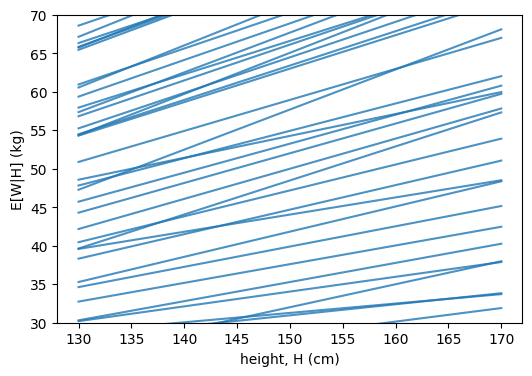

In [38]:
n_simulations = 100

alphas = np.random.normal(0, 10, n_simulations)
betas = np.random.uniform(0, 1, n_simulations)

heights_ = np.linspace(130, 170, 3)

fig, axs = plt.subplots(figsize=(6, 4))
for a, b in zip(alphas, betas):
    weights_ = a + b * heights_
    plt.plot(heights_, weights_, color='C0', alpha=.8)
    
plt.xlabel("height, H (cm)")
plt.ylabel("E[W|H] (kg)")
plt.ylim([30, 70])

#### Simulation-based Validation & Calibration
- Simulate data with varying parameters
- Vary data-generating parameters (e.g. slope) that are analogous to the model; make sure the estimator tracks
- Make sure that at large sample sizes, data-generating parameters can be recovered
- Same for confounds/unkowns

In [41]:
linear_regression_inference = []
linear_regression_models = []

sample_sizes = [1, 2, 10, 20, 50, len(H)]

for sample_size in sample_sizes:
    print(f"Samlpe Size: {sample_size}")
    
    with pm.Model() as model:
        # Mutable data for posterior predictive visualization
        H_ = pm.MutableData("H", H[:sample_size], dims="obs_id")
        
        # Priors
        sigma = pm.Uniform("sigma", 0, 10) # noise variance
        alpha = pm.Normal("alpha", mu=0, sigma=10) # intercept
        beta = pm.Uniform("beta", 0, 1) # slope
        
        # Likelihood
        mu = alpha + beta * H_
        pm.Normal("W_obs", mu=mu, sigma=sigma, observed=W[:sample_size], dims="obs_id")
        
        # Sample posterior
        trace = pm.sample(target_accept=.99)
        
        linear_regression_inference.append(trace)
        linear_regression_models.append(model)
        

Samlpe Size: 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


Samlpe Size: 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Samlpe Size: 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Samlpe Size: 20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Samlpe Size: 50


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


Samlpe Size: 200


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


#### Test Model Validity with Posterior Predictive Distrubution

Below we show:

- how the posterior becomes more specific with different numbers of observations
- how the posterior is "made of lines" -- there are an infinite number of possible lines that can be drawn from the posterior
- confidence intervals can be established to communicate the uncertainty of the posterior's fit to the data

Sampling: [W_obs]


Sample size: 1


Sampling: [W_obs]


Sample size: 2


Sampling: [W_obs]


Sample size: 10


Sampling: [W_obs]


Sample size: 20


Sampling: [W_obs]


Sample size: 50


Sampling: [W_obs]


Sample size: 200


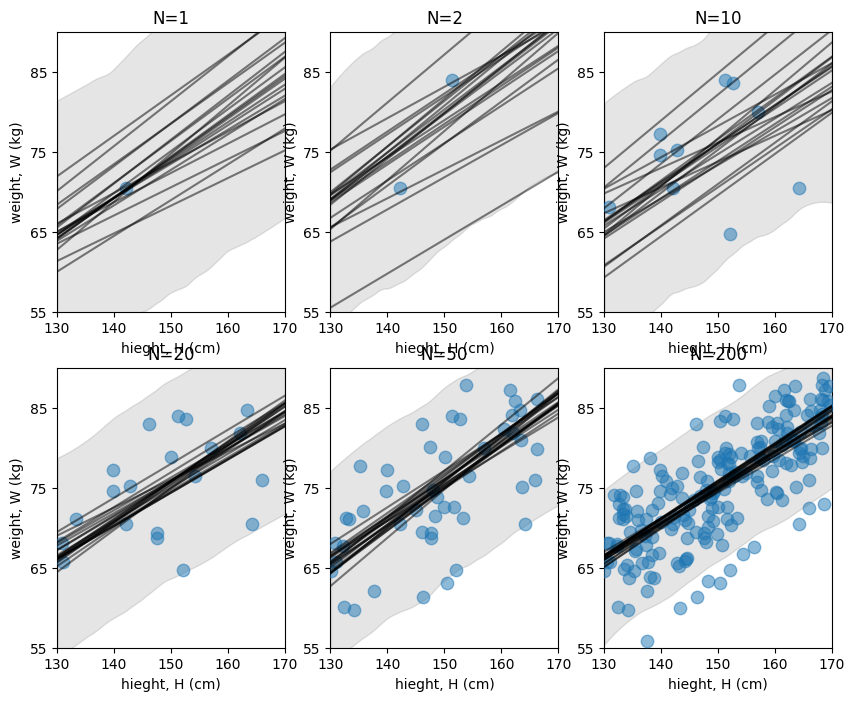

In [63]:
N_SHOW = 20
MIN_WEIGHT = 55
MAX_WEIGHT = 90

def plot_linear_regression_posterior_predictive(
    model, trace, 
    min_height=MIN_HEIGHT, max_height=MAX_HEIGHT,
    min_weight=MIN_WEIGHT, max_weight=MAX_WEIGHT,
    n_show=N_SHOW
):
    xs = np.linspace(min_height, max_height, 30)
    H_ = xr.DataArray(xs)
    
    # Sample Posterior Predictive with full range of heights
    with model:            
        pm.set_data({'H': H_})
        ppd = pm.sample_posterior_predictive(
            trace, 
            var_names=["W_obs"],
            predictions=True,
            return_inferencedata=True,
            progressbar=False
        )
    
    # Plot posterior predictive HDI
    az.plot_hdi(H_, ppd.predictions["W_obs"], color='k', fill_kwargs=dict(alpha=.1))
    
    # Plot posterior
    posterior = trace.posterior
    lines = posterior["alpha"] + posterior["beta"] * H_
    for l in lines[0, :n_show, :]:
        plt.plot(xs, l, color='k', alpha=.5, zorder=20)

    plt.xticks(np.arange(min_height, max_height + 1, 10))
    plt.xlim([min_height, max_height])    
    plt.xlabel("hieght, H (cm)")
    
    plt.ylim([min_weight, max_weight])
    plt.yticks(np.arange(min_weight, max_weight, 10))
    plt.ylabel("weight, W (kg)")
    

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for ii, (sample_size, model, inference) in enumerate(
        zip(sample_sizes, linear_regression_models, linear_regression_inference)
    ):
    print(f"Sample size: {sample_size}")
    plt.sca(axs[ii // 3][ii % 3])
    
    # Plot training data
    plt.scatter(H[:sample_size], W[:sample_size], s=80, zorder=20, alpha=.5)
    plot_linear_regression_posterior_predictive(model, inference)
    plt.title(f"N={sample_size}")

### (5) Analyze the data

In [68]:
with pm.Model() as howell_model:
    # Mutable data for posterior predictive visualization
    H_ = pm.MutableData("H", ADULT_HOWELL.height.values, dims="obs_id")
    
    # priors
    sigma = pm.Uniform("sigma", 0, 10) # noise variance
    alpha = pm.Normal("alpha", mu=0, sigma=10) # intercept
    beta = pm.Uniform("beta", 0, 1) # slope
    
    # likelihood
    mu = alpha + beta * H_
    pm.Normal("W_obs", mu=mu, sigma=sigma, observed=ADULT_HOWELL.weight.values, dims="obs_id")
    
    # sample posterior
    howell_inference = pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


In [69]:
az.summary(howell_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-43.372,4.114,-51.366,-36.160,0.125,0.089,1080.0,871.0,1.01
sigma,4.278,0.159,3.974,4.559,0.004,0.003,1369.0,1442.0,1.00
beta,0.572,0.027,0.525,0.623,0.001,0.001,1093.0,861.0,1.01


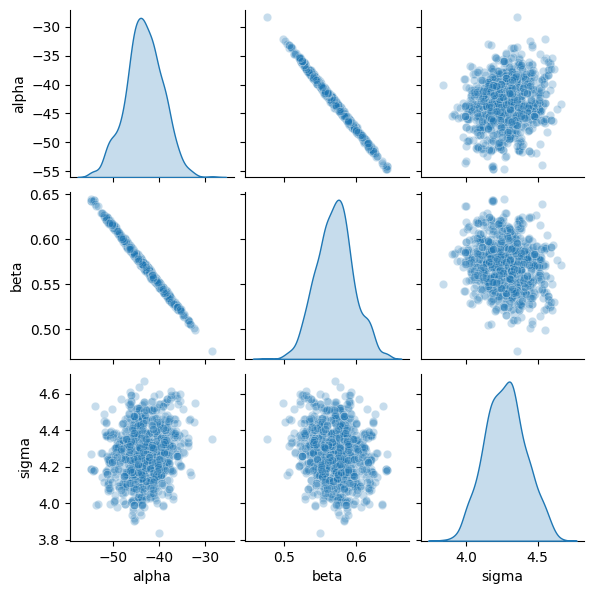

In [70]:
from seaborn import pairplot 

pairplot(
    pd.DataFrame(
        
        {
            "alpha": howell_inference.posterior.sel(chain=0)['alpha'],
            "beta": howell_inference.posterior.sel(chain=0)['beta'],
            "sigma": howell_inference.posterior.sel(chain=0)['sigma'],
        }
    ),
    diag_kind="kde",
    plot_kws={"alpha": .25},
    height=2
);

#### Important

- Parameters are not independent
- Parameter cannot be interpreted in isolation

Instead... **Push out posterior predictive**

Below, we again show:

- how the posterior is "made of lines" -- there are an infinite number of possible lines that can be drawn from the posterior
- confidence intervals can be established to communicate the uncertainty of the posterior's fit to the data


Sampling: [W_obs]


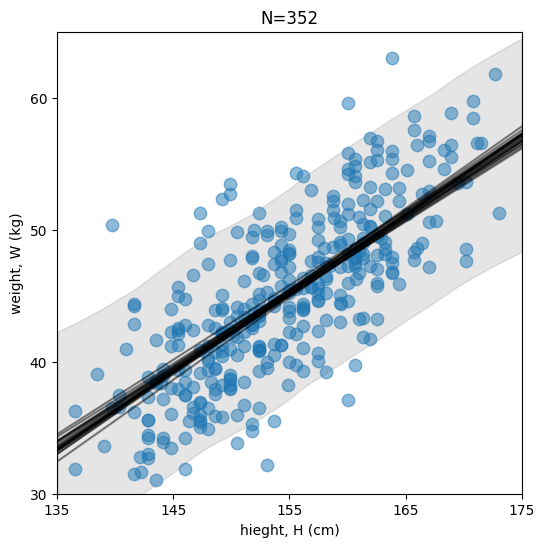

In [71]:

plt.subplots(figsize=(6, 6))
plt.scatter(ADULT_HOWELL.height.values, ADULT_HOWELL.weight.values, s=80, zorder=20, alpha=.5)
plot_linear_regression_posterior_predictive(
    howell_model,
    howell_inference,
    min_height=135,
    max_height=175,
    min_weight=30,
    max_weight=65
)  
plt.title(f"N={len(ADULT_HOWELL)}");